# Forecasting Rainfall to Anticipate Crop Failure Using ARIMA and ST-ARIMA: A Case Study of Jawa Timur, Indonesia

Forecasting the future meteorological conditions,particularly rainfall, using historical time series data is essential for crop production modeling in tropical regions. This necessity arises from the fact that, in tropical lowlands regions, agricultural activities are primarily influenced by rainfall patterns. Statistical methods such as autoregressive integrated moving average (ARIMA) and space-time autoregressive integrated moving average (STARIMA) have been widely used in forecasting rainfall or other subjects. Evaluating the applicability of those two method is essential to obtain the best model. **This research aims to assess the performance of ARIMA and ST-ARIMA to predict short-term rainfall in Jawa Timur, Indonesia.**

## Data

The data used in this study is monthly rainfall data spanning a 22-year period from 2002 to 2023 in Jawa Timur (csv format) and seasonal zone maps of Jawa Timur (shapefile), which are generated from clustering based on topography, coastal proximity, and annual rainfall patterns from the Indonesian Meteorology, Climatology, and Geophysical Agency. In total, there were **264 monthly data points**. This data is then split into a **training set (comprising 258 months from January 2002 to June 2023) and a test set (spanning 6 months from July 2023 to December 2023).**

*NB: This research **employs a seasonal zones polygon** produced by the Indonesian Meteorology, Climatology, and Geophysical Agency as spatial unit analysis instead of the administrative polygon, **as rainfall patterns are primarily shaped by atmospheric conditions and geographical features like topography rather than administrative boundaries.***

In [1]:
# Set the working directory 
# Replace the path below with the directory where your shapefile data is stored
setwd("path_file")

In [ ]:
# Install necessary R packages 
install.packages("sp")        # For spatial data structures and methods
install.packages("rgdal")     # For reading and writing spatial data formats
install.packages("raster")    # For working with raster data
install.packages("readGDAL")  #For reading GDAL data formats
install.packages("tmap")      # For thematic mapping
install.packages("ggplot2")   # For data visualization
install.packages("plyr")      # For data manipulation
install.packages("gstat")     # For geostatistical analysis
install.packages("spDataLarge") # For large spatial datasets
install.packages("knitr")     # For dynamic report generation
install.packages("forecast")  # For time series forecasting

In [3]:
# Import the 'starima' package from the specified file location
source("path_file")

In [ ]:
# Load the required libraries for analysis
library(lattice)      # For lattice plots
library(spdep)       # For spatial dependence analysis
library(sf)          # For spatial data handling
library(sftime)      # For handling time in sf objects
library(tmap)        # For thematic mapping
library(ggplot2)     # For data visualization
library(gridExtra)   # For arranging plots
library(gstat)       # For geostatistical analysis
library(OpenStreetMap)  # For accessing OpenStreetMap data
library(spacetime)   # For space-time analysis
library(stars)       # For handling raster data
library(reshape)     # For reshaping data
library(knitr)       # For dynamic report generation
library(forecast)    # For time series forecasting
library(urca)        # For unit root and cointegration analysis

In [ ]:
# Read the spatial dataset for Jawa Timur (East Java)
jatim <- st_read(dsn = "Jatim.shp", layer = "Jatim")

In [6]:
#--------------------------------------------------------------------------
# Purpose: Generate column names for a spatial dataset spanning from 
#          2002 to 2023 with month numbers prefixed, and replace existing 
#          column names in the dataset accordingly.

# Generate column names for the range 2002 to 2023 with month numbers prefixed
start_year <- 2002
end_year <- 2023
num_years <- end_year - start_year + 1

# Initialize an empty vector to store column names
column_names <- c()

# Generate column names with month numbers prefixed
for (year in start_year:end_year) {
  for (month in 1:12) {
    column_names <- c(column_names, sprintf("%02d_%d", month, year))
  }
}

# Determine the number of columns to replace
num_cols_to_replace <- min(length(column_names), ncol(jatim) - 3)

# Assign the correct column names starting from the fourth column
colnames(jatim)[4:(3 + num_cols_to_replace)] <- column_names[1:num_cols_to_replace]


In [7]:
# Create a matrix from the data without geometry information
jatim_rainfall_matrix <- data.matrix(st_drop_geometry(jatim[, -c(1:3)]))

# Set row names of the matrix to administrative division names
rownames(jatim_rainfall_matrix) <- st_drop_geometry(jatim[, "NOZONA_LAM"])[[1]]

# Print head of data
head(jatim_rainfall_matrix)

,01_2002,02_2002,03_2002,04_2002,05_2002,06_2002,07_2002,08_2002,09_2002,10_2002,⋯,03_2023,04_2023,05_2023,06_2023,07_2023,08_2023,09_2023,10_2023,11_2023,12_2023
JATIM_18,300.1,360.8,212.6,196.8,50.4,1.4,0.2,0,0.2,0.4,⋯,283.2,196.4,108.7,27.1,23.8,0.0,0.3,0.4,54.4,93.8
JATIM_21,340.9,350.3,277.8,196.6,88.0,0.2,0.3,0,0.1,3.5,⋯,324.5,182.4,128.4,39.3,40.9,0.3,0.2,6.7,90.1,145.6
JATIM_22,339.4,234.4,233.8,153.5,78.1,0.0,0.0,0,0.0,0.0,⋯,312.0,143.9,43.6,9.6,5.5,0.2,0.0,10.4,95.1,97.8


## Exploratory Data Analysis

JATIM_21 has the highest mean rainfall at 185.82 mm, while JATIM_22 has the lowest mean rainfall at 146.35 mm. In terms of
rainfall patterns shown in Figure 2, all three zones exhibit variability and do not demonstrate any clear seasonal pattern.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   14.57  136.80  152.61  269.90  481.60 

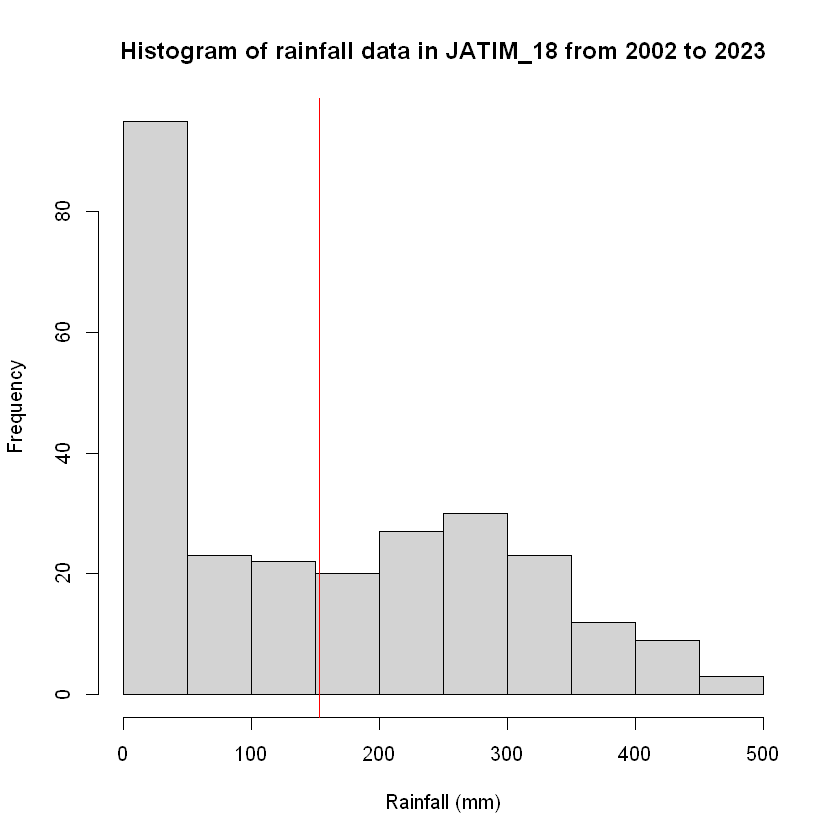

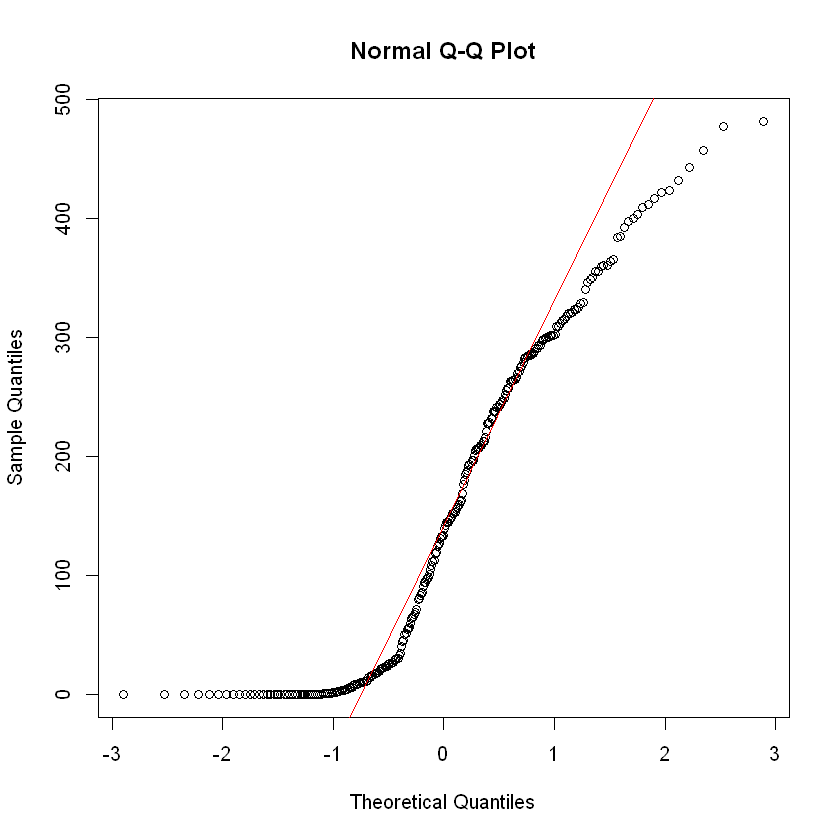

In [10]:
# JATIM_18
# Calculate summary statistic 
summary(jatim_rainfall_matrix[1, ])
# Calculate the mean rainfall
mu_18 <- mean(jatim_rainfall_matrix[1,])
# Calculate the standard deviation of rainfall
sdev_18 <- sd(jatim_rainfall_matrix[1,])

# Explore the distribution of the data using a histogram
hist(jatim_rainfall_matrix[1,], main = "Histogram of rainfall data in JATIM_18 from 2002 to 2023", xlab = "Rainfall (mm)")
# Optionally, add a vertical line at the mean (mu) on the histogram
abline(v = mu_18, col = "red")

# Check the deviation of the distribution from normality using a QQ plot
qqnorm(jatim_rainfall_matrix[1,])
qqline(jatim_rainfall_matrix[1,], col = "red")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   27.77  179.35  185.82  315.93  557.50 

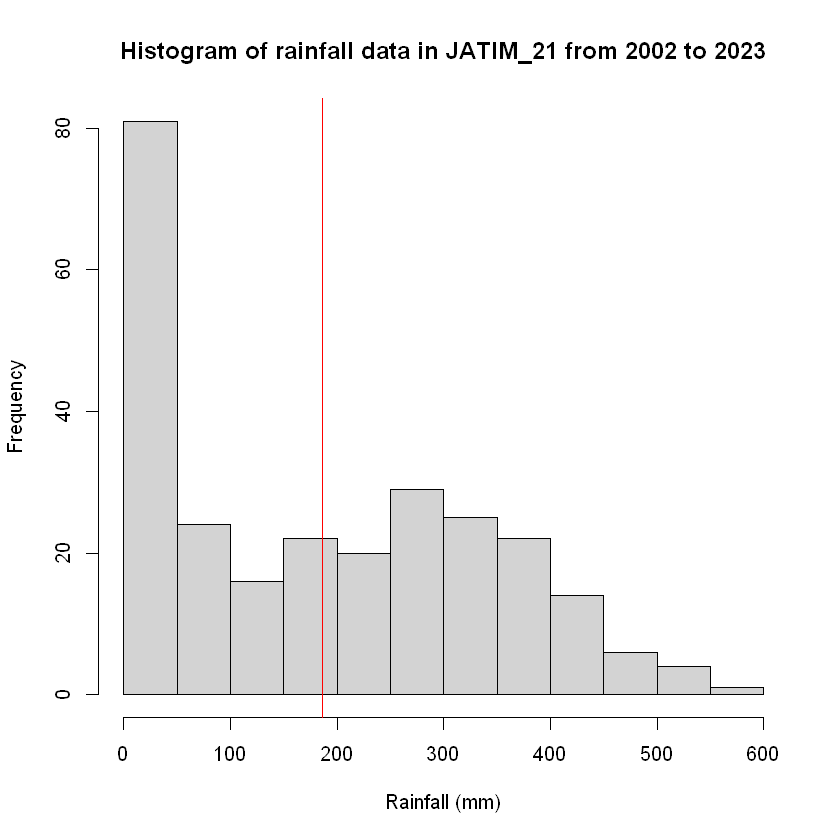

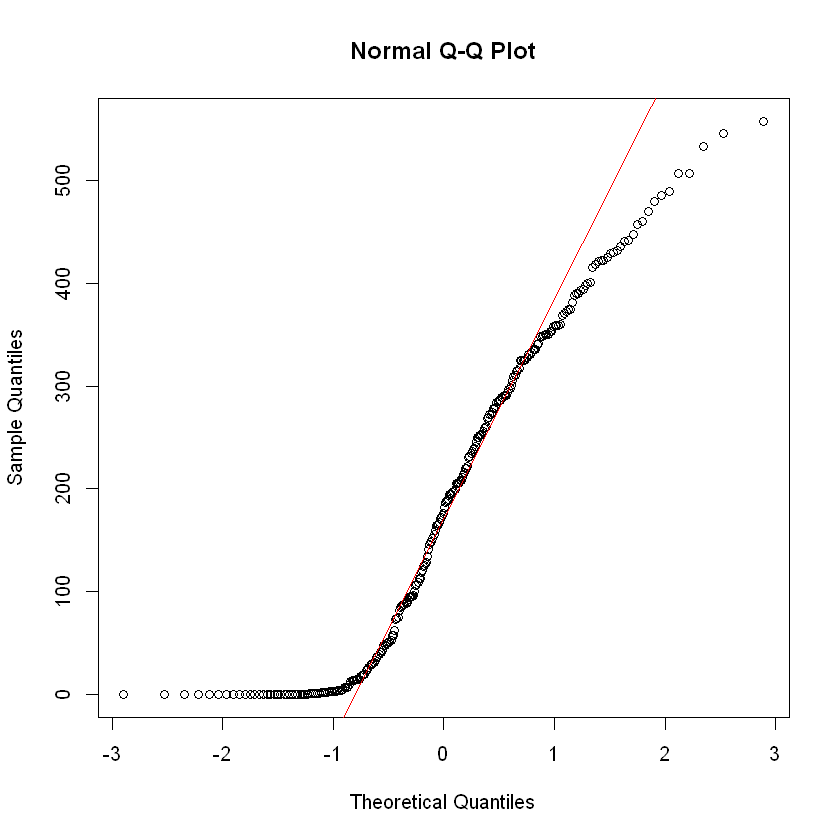

In [11]:
# JATIM_21---------------------------------------------------------------------
# Calculate summary statistic 
summary(jatim_rainfall_matrix[2, ])
# Calculate the mean rainfall
mu_21 <- mean(jatim_rainfall_matrix[2,])
# Calculate the standard deviation of rainfall
sdev_21 <- sd(jatim_rainfall_matrix[2,])

# Explore the distribution of the data using a histogram
hist(jatim_rainfall_matrix[2,], main = "Histogram of rainfall data in JATIM_21 from 2002 to 2023", xlab = "Rainfall (mm)")
# Optionally, add a vertical line at the mean (mu) on the histogram
abline(v = mu_21, col = "red")

# Check the deviation of the distribution from normality using a QQ plot
qqnorm(jatim_rainfall_matrix[2,])
qqline(jatim_rainfall_matrix[2,], col = "red")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   14.62  114.25  146.35  256.23  452.00 

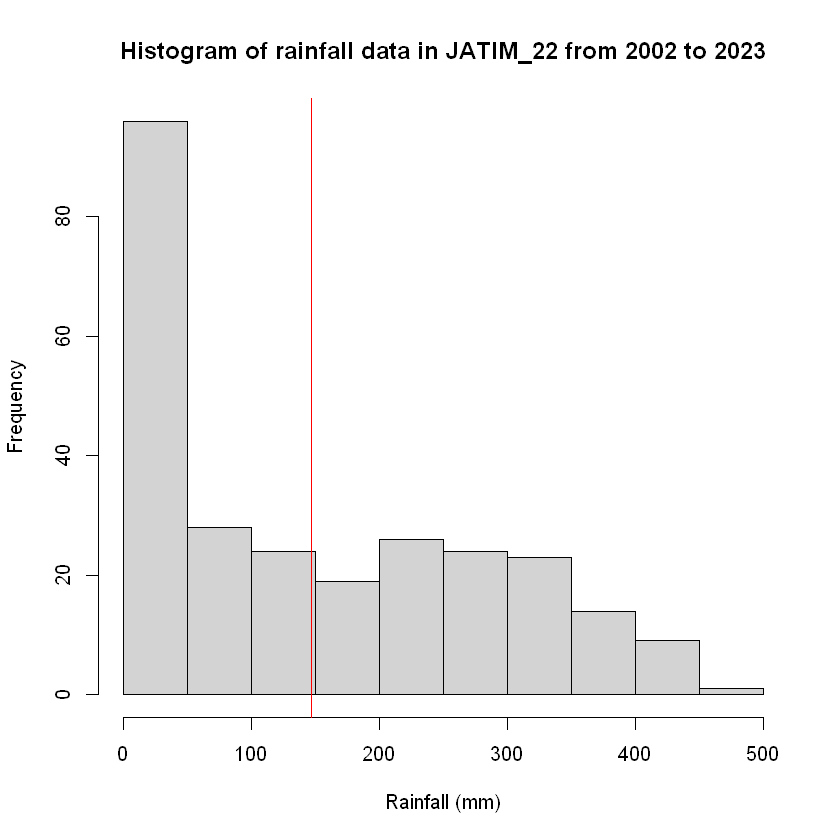

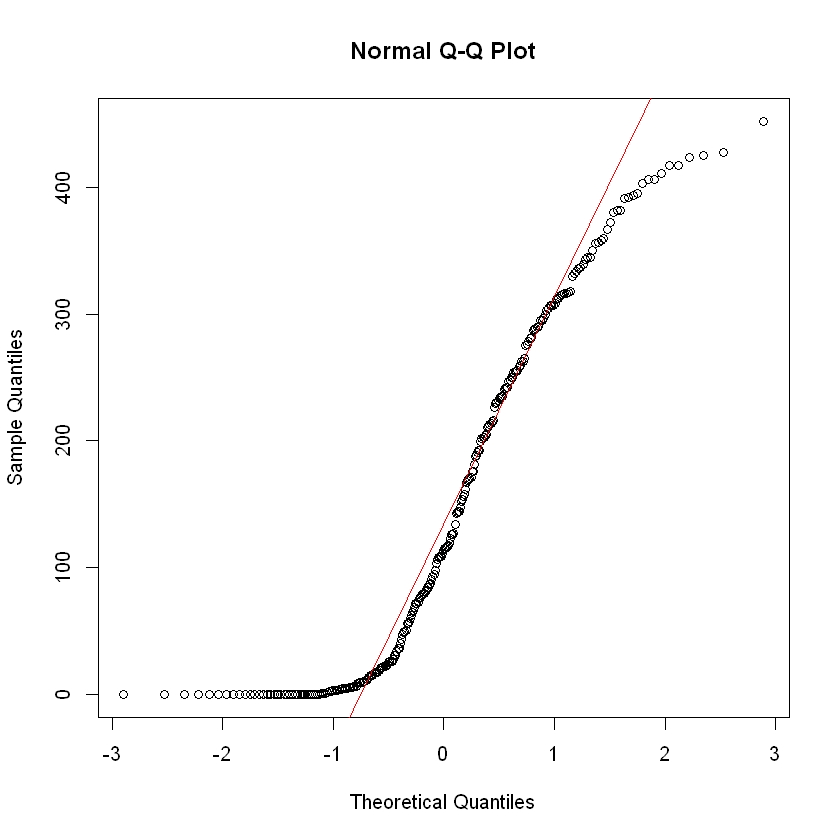

In [12]:
# JATIM_22----------------------------------------------------------------------
# Calculate summary statistic 
summary(jatim_rainfall_matrix[3, ])
# Calculate the mean rainfall
mu_22 <- mean(jatim_rainfall_matrix[3,])
# Calculate the standard deviation of rainfall
sdev_22 <- sd(jatim_rainfall_matrix[3,])

# Explore the distribution of the data using a histogram
hist(jatim_rainfall_matrix[3,], main = "Histogram of rainfall data in JATIM_22 from 2002 to 2023", xlab = "Rainfall (mm)")
# Optionally, add a vertical line at the mean (mu) on the histogram
abline(v = mu_22, col = "red")

# Check the deviation of the distribution from normality using a QQ plot
qqnorm(jatim_rainfall_matrix[3,])
qqline(jatim_rainfall_matrix[3,], col = "red")

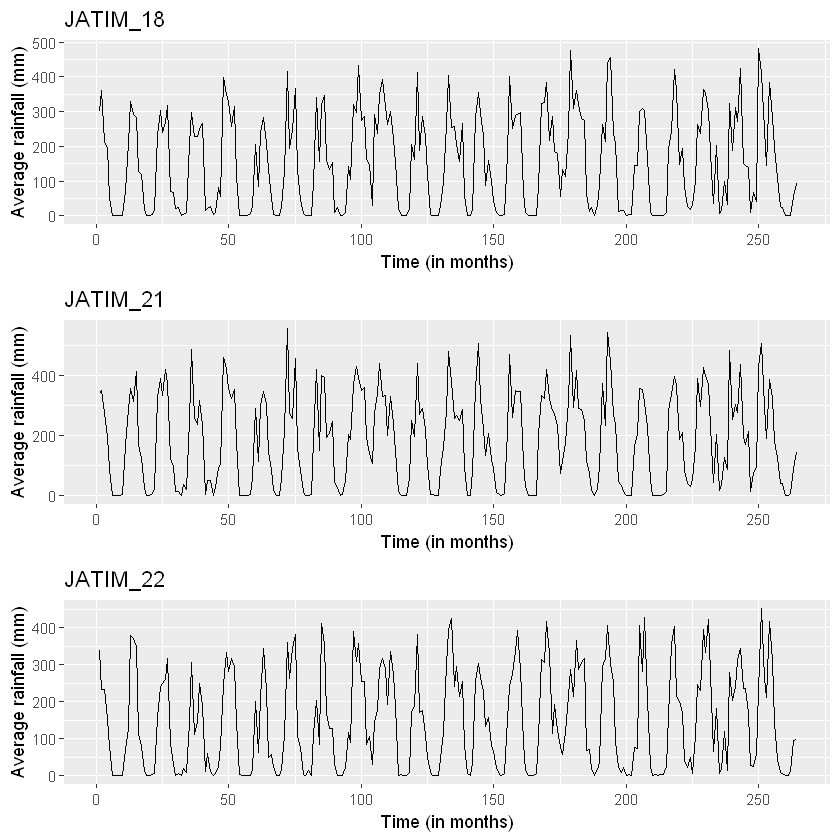

In [13]:
# Create time series plots for selected seasonal zone in Jawa Timur 
# JATIM_18
ts_data <- ts(jatim_rainfall_matrix[1,])
p1 <- autoplot(ts_data) +
  labs(x = "Time (in months)", y = "Average rainfall (mm)") +
  ggtitle("JATIM_18")

# JATIM_21
ts_data <- ts(jatim_rainfall_matrix[2,])
p2 <- autoplot(ts_data) +
  labs(x = "Time (in months)", y = "Average rainfall (mm)") +
  ggtitle("JATIM_21")

# JATIM_22
ts_data <- ts(jatim_rainfall_matrix[3,])
p3 <- autoplot(ts_data) +
  labs(x = "Time (in months)", y = "Average rainfall (mm)") +
  ggtitle("JATIM_22")

# Arrange the plots in a grid layout
grid.arrange(p1, p2, p3)

### Temporal Autocorrelation Analysis

The temporal autocorrelation for the whole dataset was calculated using the Product Moment Correlation Coefficient (PMCC). The plot on the right shows the rainfall-time trend from 2002 to 2023, while the plot on the left displays the temporal autocorrelation. Similar to the rainfall pattern in the individual zones, the full dataset exhibits variability over the time period. However, the **correlation coefficient (0.711) indicates a moderately strong positive linear relationship between the current time period (t) and the previous time period (t-1)**. Higher values of the variable at one time point tend to be
associated with higher values at the subsequent time point. Therefore, this data could potentially be used to forecast future values, thereby providing valuable insights for future analysis.

`geom_smooth()` using formula = 'y ~ x'


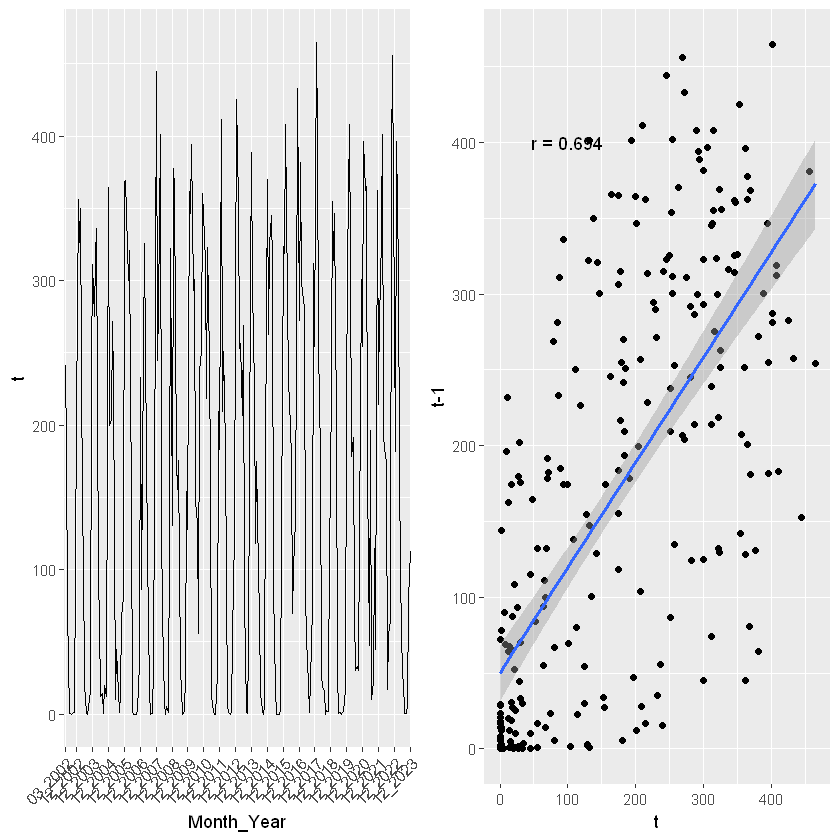

In [14]:
# Analyze and visualize lagged relationships in the mean rainfall data 

# Calculate the column means for the rainfall data starting from column 2
MeanRainfallJatim <- colMeans(jatim_rainfall_matrix[, 2:ncol(jatim_rainfall_matrix)])

# Extract the month_year information from the column names
month_year <- gsub("\\..*", "", colnames(jatim_rainfall_matrix)[-1])

# Create a lagged dataset based on the mean values
Lagged <- data.frame(month_year = month_year[-1],  # Remove the first element as there's no lag for it
                     t = MeanRainfallJatim[2:length(MeanRainfallJatim)], 
                     t_minus_1 = MeanRainfallJatim[1:(length(MeanRainfallJatim)-1)])

# Convert month_year to a factor with appropriate levels
Lagged$month_year <- factor(Lagged$month_year, levels = unique(Lagged$month_year))

# Plotting
p1 <- ggplot(Lagged, aes(x = month_year, y = t, group = 1)) + 
  geom_line() +
  labs(x = "Month_Year", y = "t") +
  scale_x_discrete(breaks = Lagged$month_year[c(1, which(as.integer(sub("_.*", "", Lagged$month_year)) %% 12 == 0), length(Lagged$month_year))],
                   labels = Lagged$month_year[c(1, which(as.integer(sub("_.*", "", Lagged$month_year)) %% 12 == 0), length(Lagged$month_year))]) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

p2 <- ggplot(Lagged, aes(x = t, y = t_minus_1)) + 
  geom_point() + 
  labs(x = "t", y = "t-1") +
  geom_smooth(method = "lm") +
  annotate("text", x = 100, y = 400, label = paste("r =", round(cor(Lagged$t, Lagged$t_minus_1), 3))) 

# Combine plots side by side
grid.arrange(p1, p2, nrow = 1)


### Spatial Autocorrelation Analysis

In [79]:
# Convert the polygon neighborhood list to a spatial weights matrix
W <- nb2listw(poly2nb(jatim))

# Display the spatial weights matrix
W

# Convert the spatial weights matrix to a matrix format
kable(listw2mat(W))

# Calculate global Moran's I correlation and Monte Carlo Simulation
jatim_rainfall_avg <- rowMeans(jatim_rainfall_matrix)
moran.test(x = jatim_rainfall_avg, listw = W)
moran.mc(x = jatim_rainfall_avg, listw = W, nsim = 20)

# Calculate local Moran's I statistics
lm <- localmoran(x = rowMeans(jatim_rainfall_matrix), listw = W)
lm


st_as_s2(): dropping Z and/or M coordinate

st_as_s2(): dropping Z and/or M coordinate



Characteristics of weights list object:
Neighbour list object:
Number of regions: 3 
Number of nonzero links: 4 
Percentage nonzero weights: 44.44444 
Average number of links: 1.333333 

Weights style: W 
Weights constants summary:
  n nn S0  S1   S2
W 3  9  3 4.5 13.5



|    |   |    |
|---:|--:|---:|
| 0.0|  1| 0.0|
| 0.5|  0| 0.5|
| 0.0|  1| 0.0|

ERROR: Error in if (VI < 0) warning("Negative variance,\ndistribution of variable does not meet test assumptions"): missing value where TRUE/FALSE needed


## Test the stationarity of time series data for selected seasonal zone in Jatim
#### Using Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests

The statistic values in the ADF test for all seasonal zones are greater than the critical values at any significance level. Therefore, the null hypothesis (presence of a unit root or non-stationarity) can be rejected. This indicates that the data in all zones are stationary according to the ADF test. Furthermore, the KPSS results show that the statistic values of all regions are smaller than any critical value at any significance level, and thus, the null hypothesis of the KPSS test (stationarity) cannot be rejected. This also suggests that the data in all zones are stationary according to the KPSS test. Therefore, **since all data is stationary, it can be directly processed using ARIMA and STARIMA without any transformation or differencing.**

In [17]:
# Time series data for JATIM_18
ts_jatim_18 <- ts(jatim_rainfall_matrix[1,])
summary(ur.df(ts_jatim_18))  # ADF
summary(ur.kpss(ts_jatim_18))  # KPSS


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-207.82  -29.89    1.44   71.79  446.44 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.15219    0.03410  -4.464  1.2e-05 ***
z.diff.lag -0.04248    0.06162  -0.689    0.491    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 108.6 on 260 degrees of freedom
Multiple R-squared:  0.08381,	Adjusted R-squared:  0.07676 
F-statistic: 11.89 on 2 and 260 DF,  p-value: 1.143e-05


Value of test-statistic is: -4.4636 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0767 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [18]:
# Time series data for JATIM_21
ts_jatim_21 <- ts(jatim_rainfall_matrix[2,])
summary(ur.df(ts_jatim_21))  # ADF
summary(ur.kpss(ts_jatim_21))  # KPSS


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-239.41  -38.41    3.21   76.20  411.01 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.14168    0.03222  -4.397  1.6e-05 ***
z.diff.lag  0.01758    0.06180   0.284    0.776    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 121.8 on 260 degrees of freedom
Multiple R-squared:  0.07167,	Adjusted R-squared:  0.06453 
F-statistic: 10.04 on 2 and 260 DF,  p-value: 6.332e-05


Value of test-statistic is: -4.3968 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0397 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [19]:
# Time series data for JATIM_22
ts_jatim_22 <- ts(jatim_rainfall_matrix[3,])
summary(ur.df(ts_jatim_22))  # ADF
summary(ur.kpss(ts_jatim_22))  # KPSS


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-216.62  -31.90    3.98   75.33  347.63 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.15300    0.03285  -4.658  5.1e-06 ***
z.diff.lag  0.06457    0.06154   1.049    0.295    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 101.7 on 260 degrees of freedom
Multiple R-squared:  0.0771,	Adjusted R-squared:   0.07 
F-statistic: 10.86 on 2 and 260 DF,  p-value: 2.952e-05


Value of test-statistic is: -4.658 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1269 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


## ARIMA

### Jatim 18
- Purpose: Analyze and model the time series data for rainfall in JATIM_18
- Training set -> jatim_rainfall_matrix [1:258] -> 01_2002 - 06_2023
- Test set -> jatim_rainfall_matrix [259:264] -> 07_2023 - 12_2023

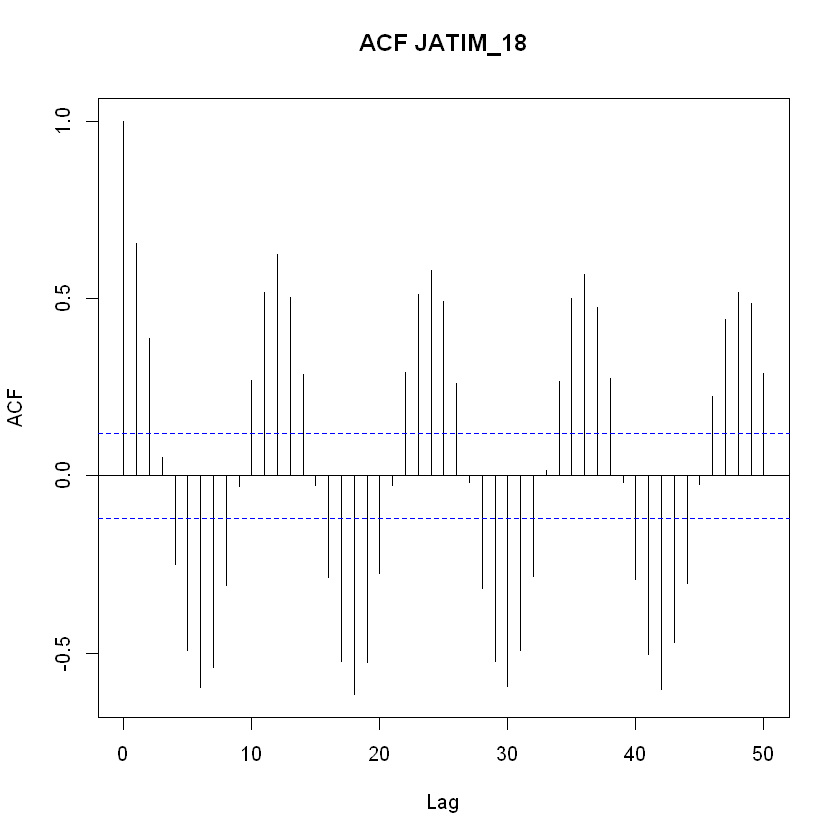

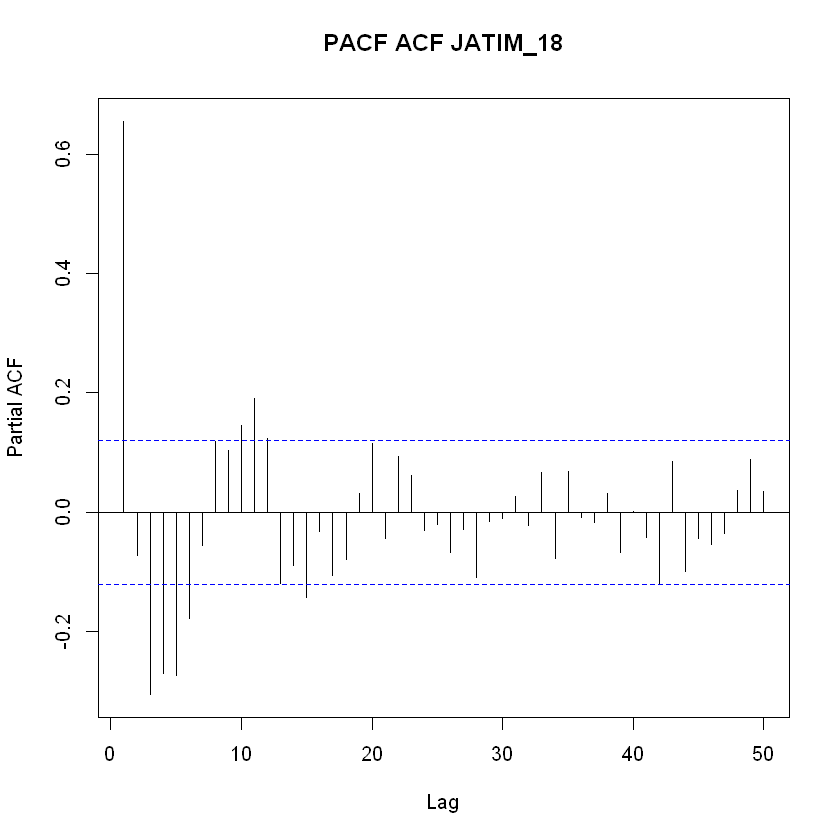

In [36]:
# Plot the autocorrelation function (ACF) 
acf(jatim_rainfall_matrix[1,], lag.max=50, main="ACF JATIM_18")

# Plot the partial autocorrelation function (PACF)
pacf(jatim_rainfall_matrix[1,], lag.max=50, main="PACF ACF JATIM_18")


In [37]:
# AutoARIMA model fitting
fit.auto.ar.18 <- auto.arima(jatim_rainfall_matrix["JATIM_18",1:258])
fit.auto.ar.18

# Model fitting with different orders
fit.ar.18.1 <- Arima(jatim_rainfall_matrix["JATIM_18", 1:258], order = c(1, 0, 1))
fit.ar.18.2 <- Arima(jatim_rainfall_matrix["JATIM_18", 1:258], order = c(1, 0, 2))

# Display model summaries
fit.ar.18.1
fit.ar.18.2
fit.auto.ar.18

Series: jatim_rainfall_matrix["JATIM_18", 1:258] 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1      mean
      0.6494  155.6025
s.e.  0.0473   18.2736

sigma^2 = 10823:  log likelihood = -1563.7
AIC=3133.39   AICc=3133.49   BIC=3144.05

Series: jatim_rainfall_matrix["JATIM_18", 1:258] 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1     ma1      mean
      0.6168  0.0574  155.5418
s.e.  0.0647  0.0706   17.6655

sigma^2 = 10837:  log likelihood = -1563.36
AIC=3134.72   AICc=3134.88   BIC=3148.93

Series: jatim_rainfall_matrix["JATIM_18", 1:258] 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1     ma1     ma2      mean
      0.4904  0.1612  0.2338  155.5374
s.e.  0.0977  0.1038  0.0670   17.1621

sigma^2 = 10412:  log likelihood = -1557.75
AIC=3125.49   AICc=3125.73   BIC=3143.26

Series: jatim_rainfall_matrix["JATIM_18", 1:258] 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1      mean
      0.6494  155.6025
s.e.  0.0473   18.2736

sigma^2 = 10823:  log likelihood = -1563.7
AIC=3133.39   AICc=3133.49   BIC=3144.05

In [38]:
# Calculate Normalized Root Mean Squared Error (NRMSE) for each model
NRMSE_fit.ar.18.1 <- NRMSE(res=fit.ar.18.1$residuals, obs=jatim_rainfall_matrix["JATIM_18",1:258])
NRMSE_fit.ar.18.2 <- NRMSE(res=fit.ar.18.2$residuals, obs=jatim_rainfall_matrix["JATIM_18",1:258])
NRMSE_fit.auto.ar.18 <- NRMSE(res=fit.auto.ar.18$residuals, obs=jatim_rainfall_matrix["JATIM_18",1:258])

# Display NRMSE values for each model
NRMSE_fit.ar.18.1
NRMSE_fit.ar.18.2
NRMSE_fit.auto.ar.18

[1] 0.7579574

[1] 0.7414837

[1] 0.7589512

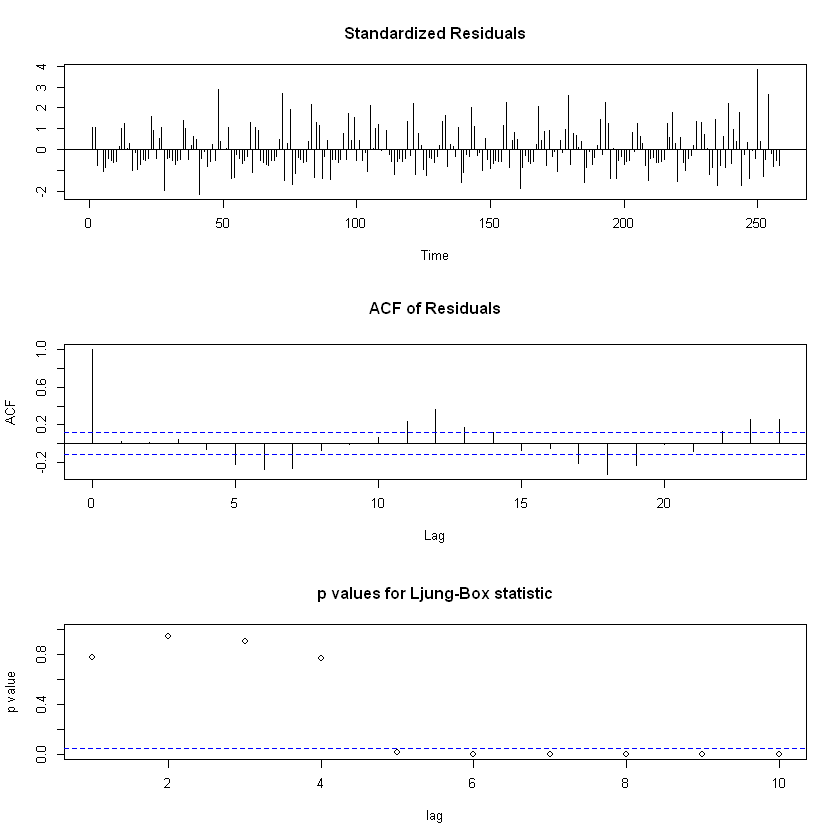

In [39]:
# Purpose: Check the normality of residuals for diagnostic purposes.
# Time series diagnostics for the best ARIMA model -> ARIMA(1,0,2)
tsdiag(fit.ar.18.2)

In [40]:
# Box-Ljung test for residual autocorrelation
# Setting the lag parameter to twice the order of the autoregressive part of the model
# This allows the test to capture any residual autocorrelation in the data beyond what is captured by the ARIMA model
Box.test(fit.ar.18.2$residuals, lag = 3)


	Box-Pierce test

data:  fit.ar.18.2$residuals
X-squared = 0.52912, df = 3, p-value = 0.9124


In [41]:
# Purpose: Perform time series forecasting for rainfall in JATIM_18
# Fit the best ARIMA model to the test set of rainfall data
pre.Ar.18 <- Arima(jatim_rainfall_matrix["JATIM_18", 259:(ncol(jatim_rainfall_matrix))], model=fit.ar.18.2)

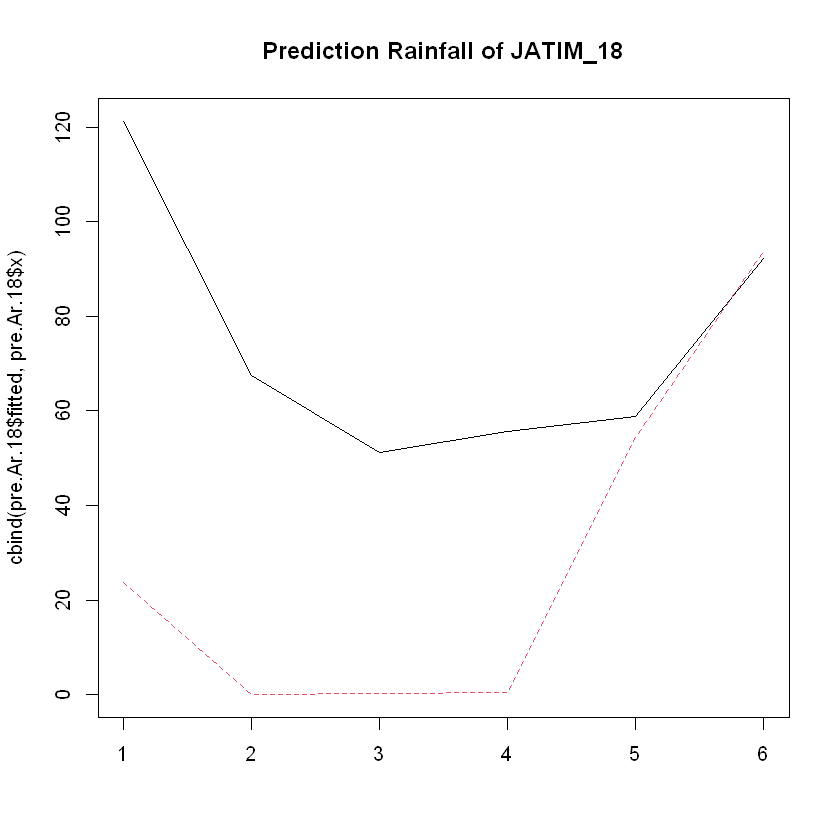

In [42]:
# Plot the observed and fitted values from the ARIMA model
matplot(cbind(pre.Ar.18$fitted, pre.Ar.18$x), type="l", main="Prediction Rainfall of JATIM_18")

In [43]:
# Calculate the Normalized Root Mean Squared Error (NRMSE) for the forecasted values
NRMSE_fit.18 <- NRMSE(res=pre.Ar.18$residuals, obs=jatim_rainfall_matrix["JATIM_18", 259:264])
NRMSE_fit.18

[1] 1.494237

### Jatim 21
- Purpose: Analyze and model the time series data for rainfall in JATIM_21
- Training set -> jatim_rainfall_matrix [1:258] -> 01_2002 - 06_2023
- Test set -> jatim_rainfall_matrix [259:264] -> 07_2023 - 12_2023

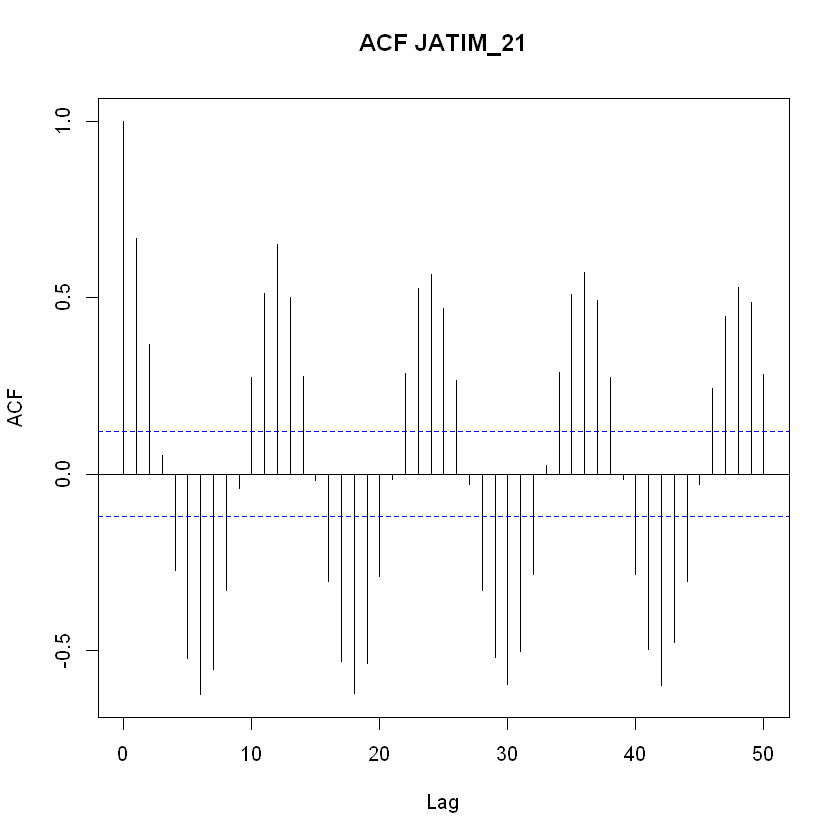

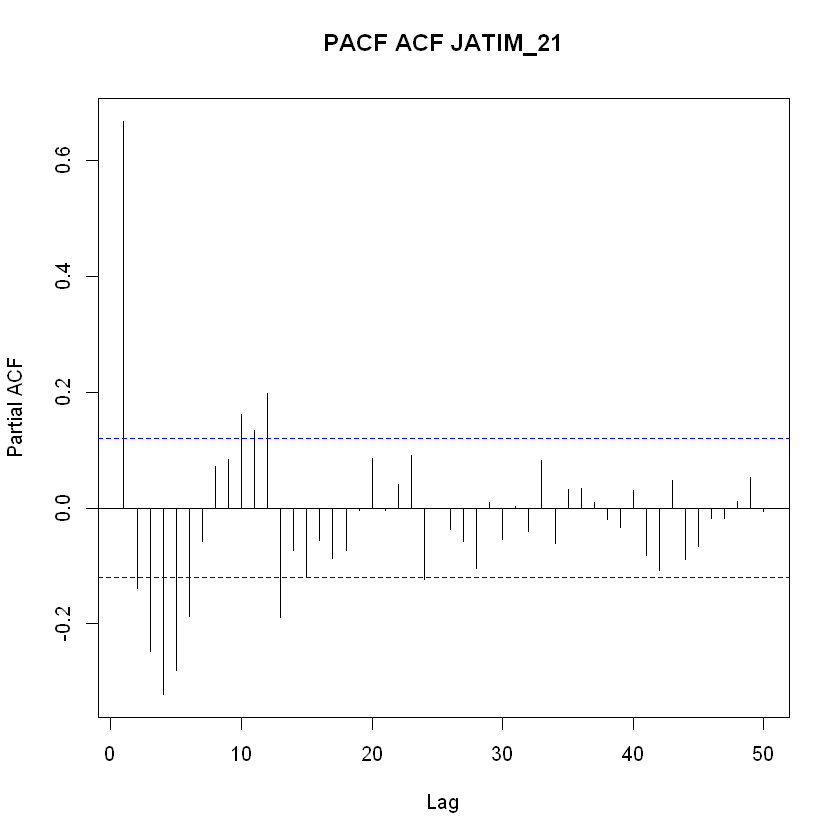

In [44]:
# Plot the autocorrelation function (ACF) 
acf(jatim_rainfall_matrix[2,], lag.max=50, main="ACF JATIM_21")

# Plot the partial autocorrelation function (PACF)
pacf(jatim_rainfall_matrix[2,], lag.max=50, main="PACF ACF JATIM_21")

In [45]:
# AutoARIMA model fitting
fit.auto.ar.21 <- auto.arima(jatim_rainfall_matrix["JATIM_21",1:258])
fit.auto.ar.21

# Model fitting with different orders
fit.ar.21.1 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(1, 0, 2))
fit.ar.21.2 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(2, 0, 2))
fit.ar.21.3 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(5, 0, 2))
fit.ar.21.4 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(6, 0, 2))
fit.ar.21.5 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(1, 0, 1))
fit.ar.21.6 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(2, 0, 1))
fit.ar.21.7 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(3, 0, 1))
fit.ar.21.8 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(4, 0, 1))
fit.ar.21.9 <- Arima(jatim_rainfall_matrix["JATIM_21", 1:258], order = c(6, 0, 1))

# Display model summaries
fit.ar.21.1
fit.ar.21.2
fit.ar.21.3
fit.ar.21.4
fit.ar.21.5
fit.ar.21.6
fit.ar.21.7
fit.ar.21.8
fit.ar.21.9
fit.auto.ar.21

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(5,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1      mean
      0.8916  -0.1642  -0.0171  -0.1239  -0.1956  -0.4052  188.3559
s.e.  0.1117   0.0998   0.0828   0.0821   0.0742   0.1011    6.0325

sigma^2 = 9945:  log likelihood = -1550.9
AIC=3117.81   AICc=3118.39   BIC=3146.23

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1     ma1     ma2      mean
      0.5096  0.1908  0.1556  188.9671
s.e.  0.0927  0.1000  0.0693   19.3766

sigma^2 = 13196:  log likelihood = -1588.3
AIC=3186.6   AICc=3186.84   BIC=3204.36

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
         ar1      ar2      ma1     ma2     mean
      1.7286  -0.9984  -1.6852  0.9996  187.935
s.e.  0.0025   0.0015   0.0444  0.0527    6.452

sigma^2 = 8062:  log likelihood = -1529.57
AIC=3071.14   AICc=3071.48   BIC=3092.46

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(5,0,2) with non-zero mean 

Coefficients:
         ar1      ar2     ar3      ar4     ar5      ma1     ma2      mean
      1.9853  -1.4523  0.3678  -0.1718  0.0918  -1.7237  0.9987  187.5944
s.e.  0.0625   0.1379  0.1629   0.1379  0.0629   0.0178  0.0233    8.2235

sigma^2 = 7682:  log likelihood = -1521.24
AIC=3060.47   AICc=3061.2   BIC=3092.45

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(6,0,2) with non-zero mean 

Coefficients:
         ar1      ar2     ar3      ar4      ar5     ar6     ma1     ma2
      1.8295  -1.0546  0.1774  -0.0896  -0.1286  0.2043  -1.365  0.4658
s.e.  0.0590      NaN  0.1275   0.1434   0.1325  0.0563     NaN     NaN
          mean
      188.4637
s.e.    9.7373

sigma^2 = 9689:  log likelihood = -1546.65
AIC=3113.3   AICc=3114.19   BIC=3148.83

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1     ma1      mean
      0.5918  0.1297  188.9884
s.e.  0.0679  0.0760   19.7021

sigma^2 = 13390:  log likelihood = -1590.66
AIC=3189.33   AICc=3189.49   BIC=3203.54

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ma1      mean
      1.5146  -0.7199  -0.8009  188.4185
s.e.  0.0505   0.0436   0.0459    6.4668

sigma^2 = 11320:  log likelihood = -1568.8
AIC=3147.59   AICc=3147.83   BIC=3165.36

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(3,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ma1      mean
      1.2635  -0.2943  -0.2731  -0.6990  188.4152
s.e.  0.0743   0.1065   0.0639   0.0525    6.3762

sigma^2 = 10664:  log likelihood = -1560.72
AIC=3133.45   AICc=3133.78   BIC=3154.77

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(4,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ma1      mean
      1.0785  -0.2563  -0.0015  -0.2641  -0.5621  188.3639
s.e.  0.0836   0.0985   0.0909   0.0665   0.0676    6.1793

sigma^2 = 10146:  log likelihood = -1553.93
AIC=3121.85   AICc=3122.3   BIC=3146.72

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(6,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ar6      ma1      mean
      0.6487  -0.0566  -0.0039  -0.1307  -0.1543  -0.1581  -0.1769  188.4127
s.e.  0.1909   0.1203   0.0733   0.0722   0.0758   0.0851   0.1870    5.9132

sigma^2 = 9870:  log likelihood = -1549.46
AIC=3116.91   AICc=3117.64   BIC=3148.89

Series: jatim_rainfall_matrix["JATIM_21", 1:258] 
ARIMA(5,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1      mean
      0.8916  -0.1642  -0.0171  -0.1239  -0.1956  -0.4052  188.3559
s.e.  0.1117   0.0998   0.0828   0.0821   0.0742   0.1011    6.0325

sigma^2 = 9945:  log likelihood = -1550.9
AIC=3117.81   AICc=3118.39   BIC=3146.23

In [46]:
# Calculate Normalized Root Mean Squared Error (NRMSE) for each model
NRMSE_fit.ar.21.1 <- NRMSE(res=fit.ar.21.1$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.2 <- NRMSE(res=fit.ar.21.2$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.3 <- NRMSE(res=fit.ar.21.3$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.4 <- NRMSE(res=fit.ar.21.4$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.5 <- NRMSE(res=fit.ar.21.5$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.6 <- NRMSE(res=fit.ar.21.6$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.7 <- NRMSE(res=fit.ar.21.7$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.8 <- NRMSE(res=fit.ar.21.8$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.ar.21.9 <- NRMSE(res=fit.ar.21.9$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])
NRMSE_fit.auto.ar.21 <- NRMSE(res=fit.auto.ar.21$residuals, obs=jatim_rainfall_matrix["JATIM_21",1:258])

# Display NRMSE values for each model
NRMSE_fit.ar.21.1
NRMSE_fit.ar.21.2
NRMSE_fit.ar.21.3
NRMSE_fit.ar.21.4
NRMSE_fit.ar.21.5
NRMSE_fit.ar.21.6
NRMSE_fit.ar.21.7
NRMSE_fit.ar.21.8
NRMSE_fit.ar.21.9
NRMSE_fit.auto.ar.21


[1] 0.7366718

[1] 0.5746691

[1] 0.5576339

[1] 0.6249923

[1] 0.743514

[1] 0.6822944

[1] 0.6609394

[1] 0.6434007

[1] 0.6320713

[1] 0.6357247

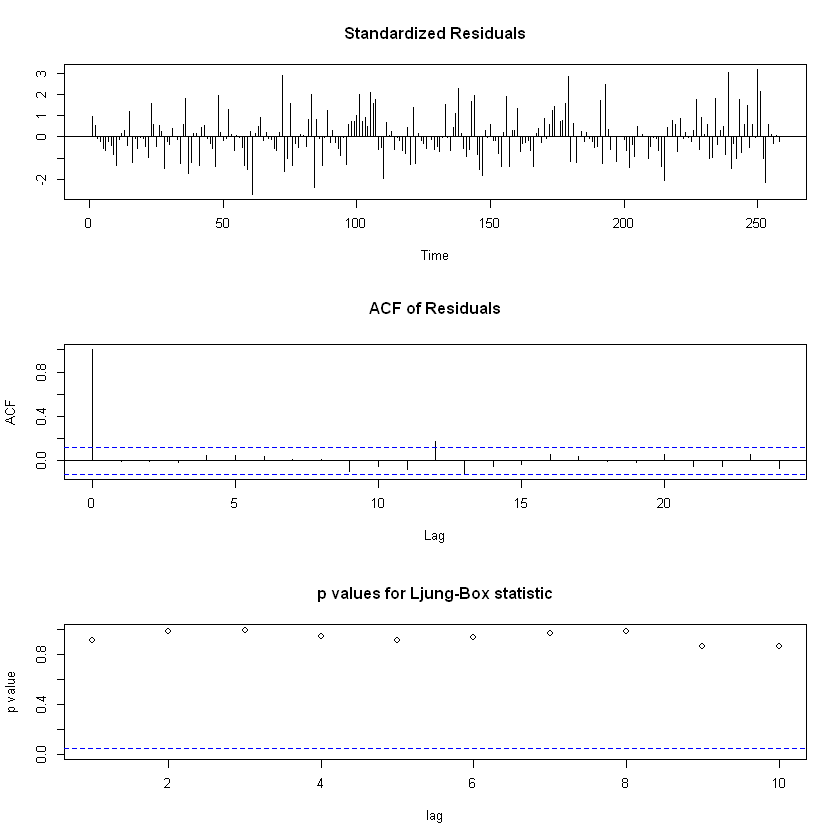

In [47]:
# Purpose: Check the normality of residuals for diagnostic purposes.
# Time series diagnostics for the best ARIMA model -> ARIMA(5,0,2)
tsdiag(fit.ar.21.3)

In [48]:
# Box-Ljung test for residual autocorrelation
# Setting the lag parameter to twice the order of the autoregressive part of the model
# This allows the test to capture any residual autocorrelation in the data beyond what is captured by the ARIMA model
Box.test(fit.ar.21.3$residuals, lag = 10)


	Box-Pierce test

data:  fit.ar.21.3$residuals
X-squared = 5.1087, df = 10, p-value = 0.8838


In [49]:
# Purpose: Perform time series forecasting for rainfall in JATIM_21
# Fit the best ARIMA model to the test set of rainfall data
pre.Ar.21 <- Arima(jatim_rainfall_matrix["JATIM_21", 259:(ncol(jatim_rainfall_matrix))], model=fit.ar.21.3)

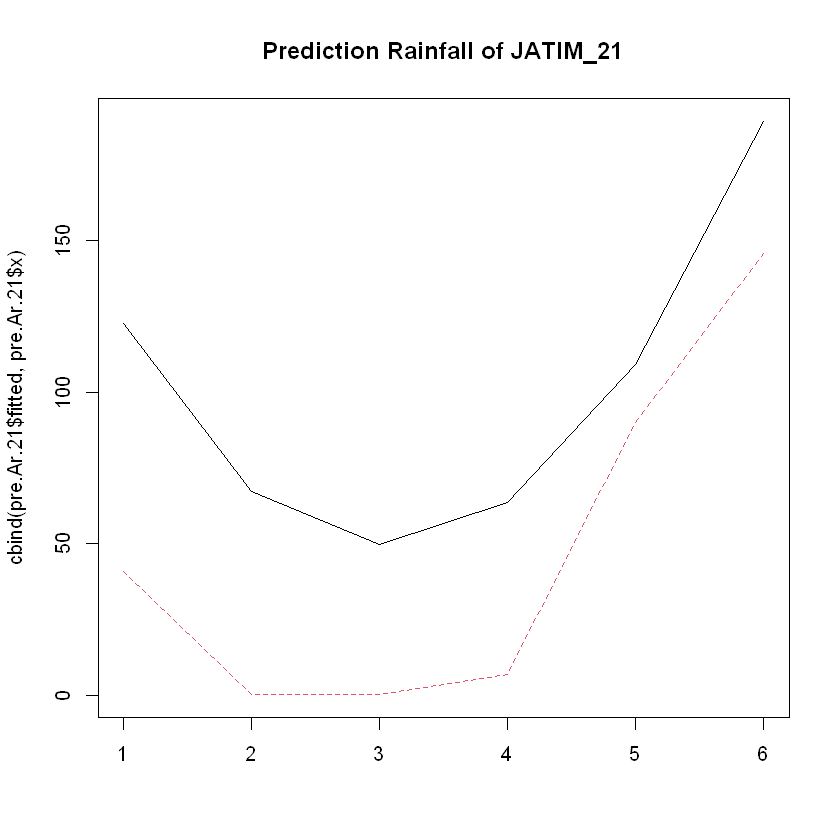

In [50]:
# Plot the observed and fitted values from the ARIMA model
matplot(cbind(pre.Ar.21$fitted, pre.Ar.21$x), type="l", main="Prediction Rainfall of JATIM_21")

In [51]:
# Calculate the Normalized Root Mean Squared Error (NRMSE) for the forecasted values
NRMSE_fit.21 <- NRMSE(res=pre.Ar.21$residuals, obs=jatim_rainfall_matrix["JATIM_21", 259:264])
NRMSE_fit.21

[1] 0.9504749

### Jatim 22
- Purpose: Analyze and model the time series data for rainfall in JATIM_22
- Training set -> jatim_rainfall_matrix [1:258] -> 01_2002 - 06_2023
- Test set -> jatim_rainfall_matrix [259:264] -> 07_2023 - 12_2023

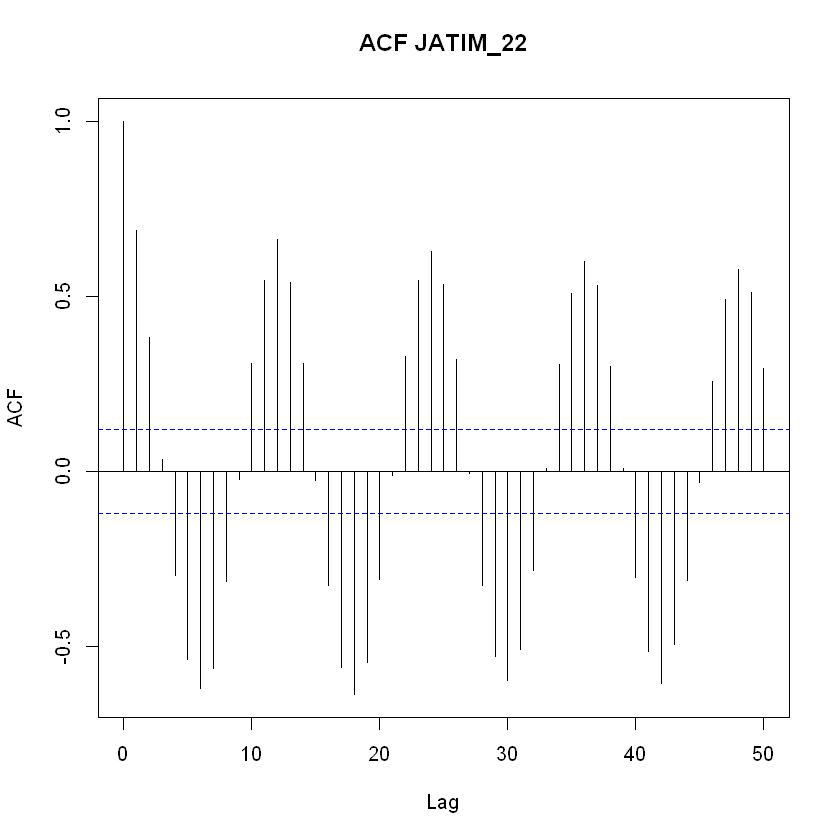

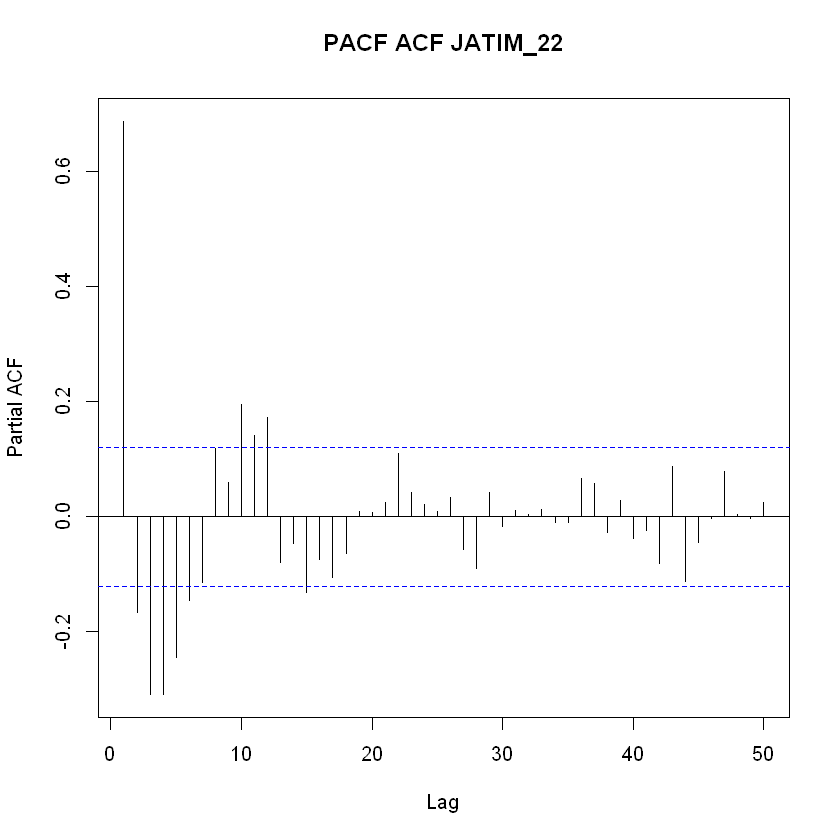

In [52]:
# Plot the autocorrelation function (ACF) 
acf(jatim_rainfall_matrix[3,], lag.max=50, main="ACF JATIM_22")

# Plot the partial autocorrelation function (PACF)
pacf(jatim_rainfall_matrix[3,], lag.max=50, main="PACF ACF JATIM_22")


In [53]:
# AutoARIMA model fitting
fit.auto.ar.22 <- auto.arima(jatim_rainfall_matrix["JATIM_22",1:258])
fit.auto.ar.22

# Model fitting with different orders
fit.ar.22.1 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(1, 0, 2))
fit.ar.22.2 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(2, 0, 2))
fit.ar.22.3 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(4, 0, 2))
fit.ar.22.4 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(5, 0, 2))
fit.ar.22.5 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(6, 0, 2))
fit.ar.22.6 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(1, 0, 1))
fit.ar.22.7 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(2, 0, 1))
fit.ar.22.8 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(3, 0, 1))
fit.ar.22.9 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(4, 0, 1))
fit.ar.22.10 <- Arima(jatim_rainfall_matrix["JATIM_22", 1:258], order = c(6, 0, 1))

# Display model summaries
fit.ar.22.1
fit.ar.22.2
fit.ar.22.3
fit.ar.22.4
fit.ar.22.5
fit.ar.22.6
fit.ar.22.7
fit.ar.22.8
fit.ar.22.9
fit.ar.22.10
fit.auto.ar.22

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(5,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1      mean
      0.9286  -0.1551  -0.0825  -0.1116  -0.1597  -0.3983  148.2399
s.e.  0.1236   0.1073   0.0853   0.0841   0.0767   0.1131    5.3958

sigma^2 = 7059:  log likelihood = -1506.7
AIC=3029.41   AICc=3029.99   BIC=3057.83

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1     ma1     ma2      mean
      0.5122  0.2177  0.2175  149.3611
s.e.  0.0868  0.0923  0.0695   17.3589

sigma^2 = 9227:  log likelihood = -1542.21
AIC=3094.41   AICc=3094.65   BIC=3112.18

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
         ar1      ar2      ma1     ma2      mean
      1.7311  -0.9994  -1.7053  1.0000  147.5303
s.e.  0.0013   0.0007   0.0185  0.0198    5.0880

sigma^2 = 5643:  log likelihood = -1483.55
AIC=2979.1   AICc=2979.44   BIC=3000.42

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(4,0,2) with non-zero mean 

Coefficients:
         ar1      ar2     ar3     ar4      ma1     ma2      mean
      2.0054  -1.4570  0.2440  0.0173  -1.7228  0.9971  147.4346
s.e.  0.0618   0.1391  0.1341  0.0560      NaN     NaN    6.4512

sigma^2 = 5330:  log likelihood = -1474.29
AIC=2964.57   AICc=2965.15   BIC=2992.99

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(5,0,2) with non-zero mean 

Coefficients:
         ar1     ar2      ar3      ar4      ar5     ma1      ma2      mean
      0.1724  0.7041  -0.2688  -0.2194  -0.2726  0.3855  -0.4469  148.2491
s.e.  0.1039  0.0929   0.0945   0.0653   0.0686  0.0958   0.0816    5.5053

sigma^2 = 7039:  log likelihood = -1505.85
AIC=3029.71   AICc=3030.44   BIC=3061.69

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(6,0,2) with non-zero mean 

Coefficients:
         ar1      ar2     ar3     ar4      ar5     ar6      ma1     ma2
      2.0118  -1.4607  0.2732  0.0376  -0.0934  0.0744  -1.7372  0.9985
s.e.  0.0628   0.1403  0.1670  0.1669   0.1402  0.0626      NaN     NaN
          mean
      147.3386
s.e.    7.3838

sigma^2 = 5314:  log likelihood = -1473.25
AIC=2966.5   AICc=2967.39   BIC=3002.03

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1     ma1      mean
      0.6133  0.1434  149.3657
s.e.  0.0635  0.0698   17.7421

sigma^2 = 9523:  log likelihood = -1546.73
AIC=3101.47   AICc=3101.62   BIC=3115.68

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ma1      mean
      1.5247  -0.7407  -0.7681  148.4022
s.e.  0.0487   0.0426   0.0439    5.9647

sigma^2 = 7889:  log likelihood = -1522.25
AIC=3054.51   AICc=3054.75   BIC=3072.27

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(3,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ma1      mean
      1.2499  -0.2760  -0.2952  -0.6573  148.3411
s.e.  0.0745   0.1071   0.0639   0.0539    5.6966

sigma^2 = 7358:  log likelihood = -1512.92
AIC=3037.85   AICc=3038.18   BIC=3059.16

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(4,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3     ar4      ma1      mean
      1.0881  -0.2316  -0.0786  -0.217  -0.5376  148.2779
s.e.  0.0898   0.1026   0.0924   0.070   0.0736    5.5245

sigma^2 = 7141:  log likelihood = -1508.65
AIC=3031.29   AICc=3031.74   BIC=3056.16

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(6,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ar6      ma1      mean
      0.7643  -0.0771  -0.0749  -0.1244  -0.1257  -0.1074  -0.2432  148.2698
s.e.  0.1865   0.1253   0.0787   0.0777   0.0808   0.0816   0.1794    5.2696

sigma^2 = 7045:  log likelihood = -1505.95
AIC=3029.91   AICc=3030.63   BIC=3061.88

Series: jatim_rainfall_matrix["JATIM_22", 1:258] 
ARIMA(5,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1      mean
      0.9286  -0.1551  -0.0825  -0.1116  -0.1597  -0.3983  148.2399
s.e.  0.1236   0.1073   0.0853   0.0841   0.0767   0.1131    5.3958

sigma^2 = 7059:  log likelihood = -1506.7
AIC=3029.41   AICc=3029.99   BIC=3057.83

In [54]:
# Calculate Normalized Root Mean Squared Error (NRMSE) for each model
NRMSE_fit.ar.22.1 <- NRMSE(res=fit.ar.22.1$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.2 <- NRMSE(res=fit.ar.22.2$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.3 <- NRMSE(res=fit.ar.22.3$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.4 <- NRMSE(res=fit.ar.22.4$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.5 <- NRMSE(res=fit.ar.22.5$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.6 <- NRMSE(res=fit.ar.22.6$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.7 <- NRMSE(res=fit.ar.22.7$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.8 <- NRMSE(res=fit.ar.22.8$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.9 <- NRMSE(res=fit.ar.22.9$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.ar.22.10 <- NRMSE(res=fit.ar.22.10$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])
NRMSE_fit.auto.ar.22 <- NRMSE(res=fit.auto.ar.22$residuals, obs=jatim_rainfall_matrix["JATIM_22",1:258])

# Display NRMSE values for each model
NRMSE_fit.ar.22.1
NRMSE_fit.ar.22.2
NRMSE_fit.ar.22.3
NRMSE_fit.ar.22.4
NRMSE_fit.ar.22.5
NRMSE_fit.ar.22.6
NRMSE_fit.ar.22.7
NRMSE_fit.ar.22.8
NRMSE_fit.ar.22.9
NRMSE_fit.ar.22.10
NRMSE_fit.auto.ar.22

[1] 0.7092723

[1] 0.5535828

[1] 0.5358404

[1] 0.6145743

[1] 0.5329332

[1] 0.7219466

[1] 0.6557987

[1] 0.6321165

[1] 0.6214811

[1] 0.6148509

[1] 0.6166908

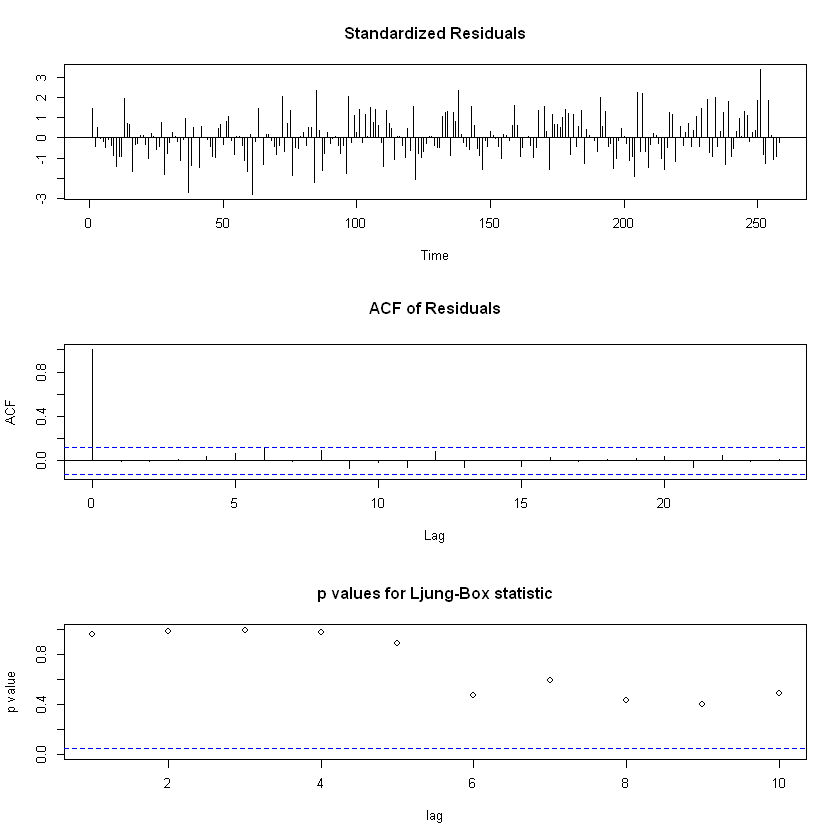

In [55]:
# Purpose: Check the normality of residuals for diagnostic purposes.
# Time series diagnostics for the best ARIMA model -> ARIMA(4,0,2)
tsdiag(fit.ar.22.3)

In [56]:
# Box-Ljung test for residual autocorrelation
# Setting the lag parameter to twice the order of the autoregressive part of the model
# This allows the test to capture any residual autocorrelation in the data beyond what is captured by the ARIMA model
Box.test(fit.ar.22.3$residuals, lag = 8)


	Box-Pierce test

data:  fit.ar.22.3$residuals
X-squared = 7.7941, df = 8, p-value = 0.4538


In [57]:
# Purpose: Perform time series forecasting for rainfall in JATIM_22
# Fit the best ARIMA model to the test set of rainfall data
pre.Ar.22 <- Arima(jatim_rainfall_matrix["JATIM_22", 259:(ncol(jatim_rainfall_matrix))], model=fit.ar.22.3)

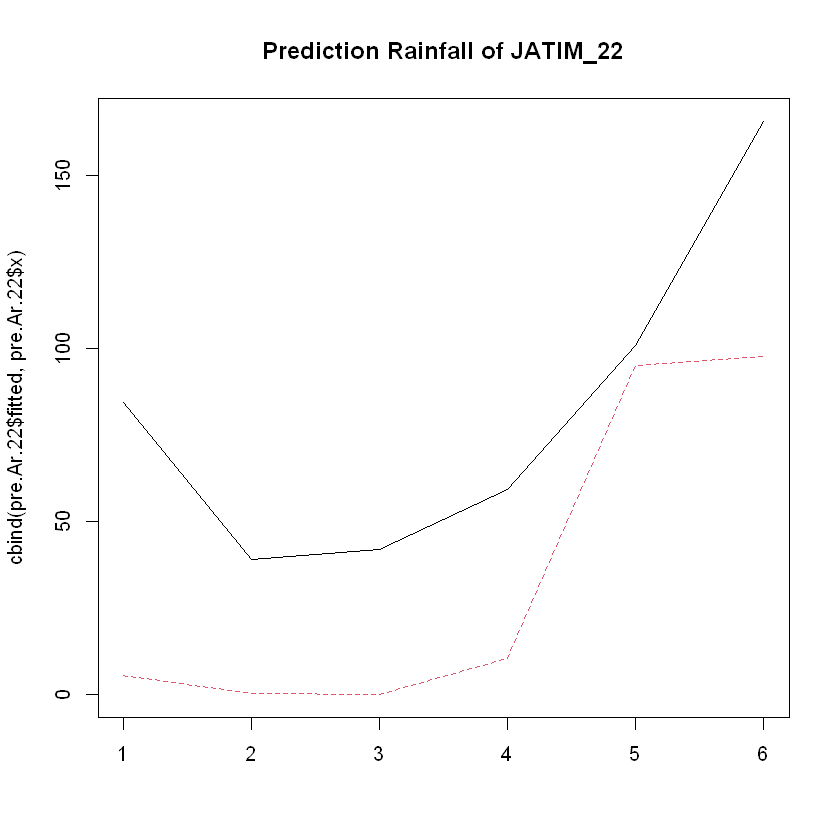

In [58]:
# Plot the observed and fitted values from the ARIMA model
matplot(cbind(pre.Ar.22$fitted, pre.Ar.22$x), type="l", main="Prediction Rainfall of JATIM_22")


In [59]:
# Calculate the Normalized Root Mean Squared Error (NRMSE) for the forecasted values
NRMSE_fit.22 <- NRMSE(res=pre.Ar.22$residuals, obs=jatim_rainfall_matrix["JATIM_22", 259:264])
NRMSE_fit.22

[1] 1.095211

## ST-ARIMA

In [60]:
# Purpose: Convert polygon neighbors to a binary spatial weights matrix.
# Create neighborhood structure from polygon neighbors
nbrs <- poly2nb(jatim)

# Convert the neighborhood structure to a binary spatial weights matrix
W1 <- nb2mat(nbrs)

# Create an identity matrix with dimensions matching the spatial weights matrix
W0 <- diag(x=1, nrow(W1), ncol(W1)) # Spatial order zero


st_as_s2(): dropping Z and/or M coordinate

st_as_s2(): dropping Z and/or M coordinate



In [61]:
# Purpose: Calculate spatial-temporal autocorrelation functions (STACF and STPACF) for rainfall data in Jawa Timur.
# Transpose the rainfall matrix to have time series in columns (STACF and STPACF require this format)
jatim_rainfall_mat2 <- t(jatim_rainfall_matrix)

1.00000000
0.67234231
0.38275373
0.04646230
-0.27795762
-0.52728696
-0.62879819
-0.56807517
-0.32720698
-0.03217068
0.29525452


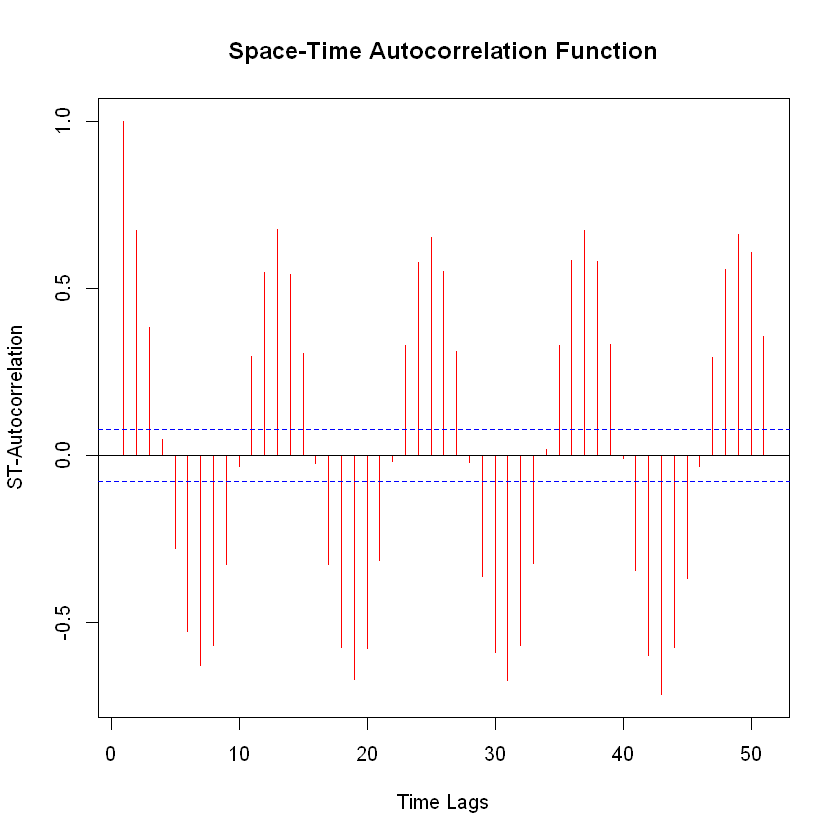

In [63]:
#Model Identification
# Calculate the spatial-temporal autocorrelation function (STACF) for the rainfall data using a spatial weights matrix
stacf(jatim_rainfall_mat2, W0, 50) # Spatial order zero

0.0426904753
-0.1085540402
0.0014381101
0.0052505177
0.0225072763
0.0527946588
0.0654087966
0.0880259055
0.0523955698
-0.0057727154
-0.0495230951


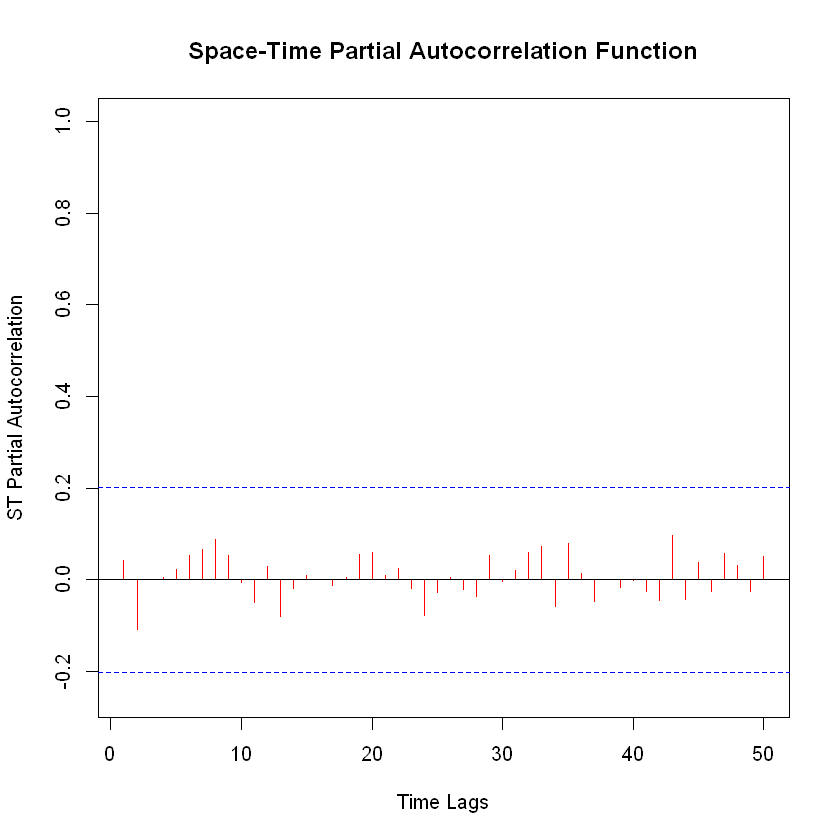

In [64]:
# Calculate the spatial-temporal partial autocorrelation function (STPACF) for the rainfall data using a spatial weights matrix
stpacf(jatim_rainfall_mat2, W1, 50) # Spatial order one

In [65]:
#Parameter Estimation and Fitting--------------------------------------------
# Create a list of spatial weight matrices, where zero elements are not needed
W_fit <- list(w1 = W1)

In [66]:
# Fit space-time autoregressive integrated moving average (STARIMA) models with different orders
fit.star1 <- starima_fit(Z = jatim_rainfall_mat2[1:258, ], W = W_fit, p = 1, d = 0, q = 1)
fit.star2 <- starima_fit(Z = jatim_rainfall_mat2[1:258, ], W = W_fit, p = 1, d = 0, q = 2)

fit.star1
fit.star2

,JATIM_18,JATIM_21,JATIM_22
03_2002,212.6,277.8,233.8
04_2002,196.8,196.6,153.5
05_2002,50.4,88.0,78.1
06_2002,1.4,0.2,0.0
07_2002,0.2,0.3,0.0
08_2002,0.0,0.0,0.0
09_2002,0.2,0.1,0.0
10_2002,0.4,3.5,0.0
11_2002,71.8,167.5,72.2
12_2002,207.8,288.7,126.4


,JATIM_18,JATIM_21,JATIM_22
04_2002,196.8,196.6,153.5
05_2002,50.4,88.0,78.1
06_2002,1.4,0.2,0.0
07_2002,0.2,0.3,0.0
08_2002,0.0,0.0,0.0
09_2002,0.2,0.1,0.0
10_2002,0.4,3.5,0.0
11_2002,71.8,167.5,72.2
12_2002,207.8,288.7,126.4
01_2003,329.2,358.7,380.0


In [67]:
# Extract NRMSE values from STARIMA model fits
# NRMSE: Normalized Root Mean Squared Error, indicating the goodness-of-fit of the models
fit.star1$NRMSE
fit.star2$NRMSE # The best ST-ARIMA(1,0,2) model (The lowest NRMSE)

[1] 0.8018773 0.7904392 0.7597683

[1] 0.7909154 0.7905659 0.7666424

1.0000000000
-0.0254702392
0.0325663377
-0.0225096861
-0.0600437944
-0.2431724076
-0.2421166231
-0.2754764668
-0.0725421742
-0.0111070966
0.1379971978


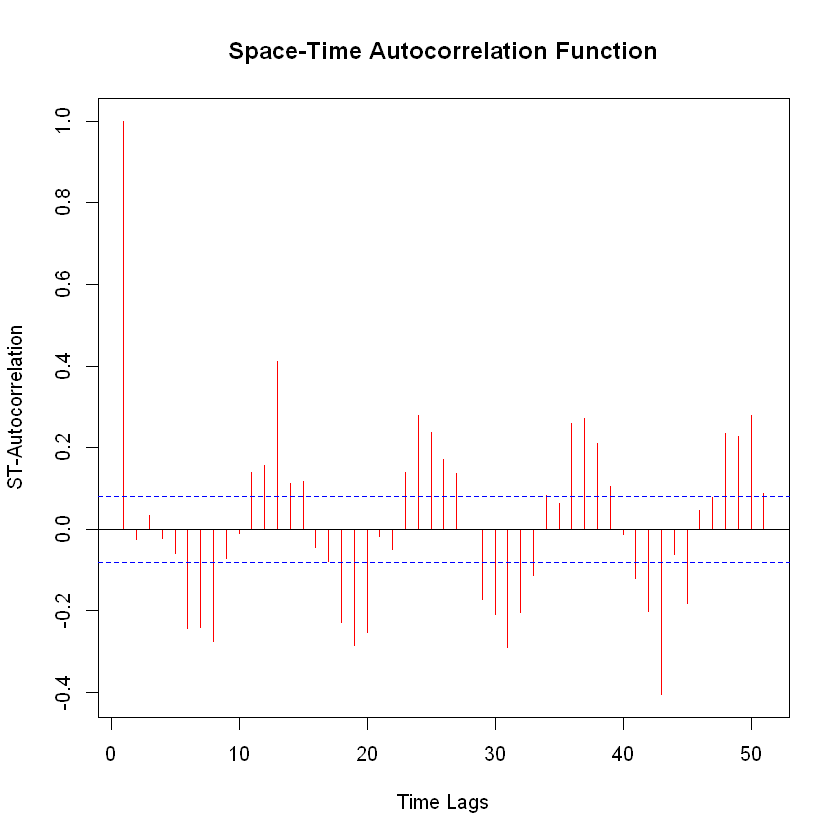

In [68]:
# Diagnostic Checking----------------------------------------------------------
stacf(fit.star2$RES,W1,50) 


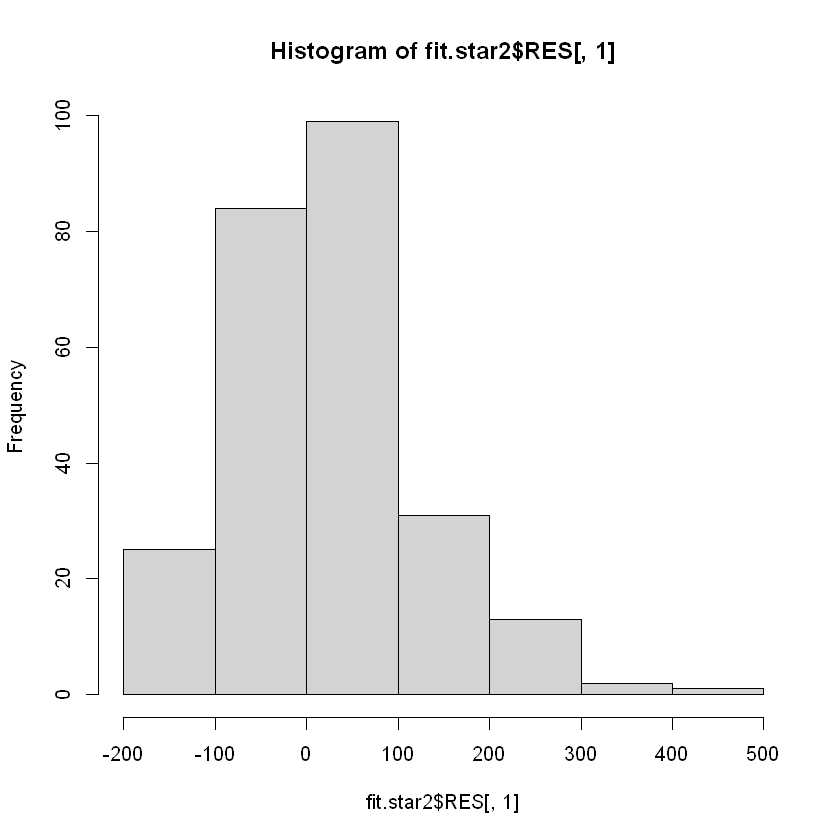

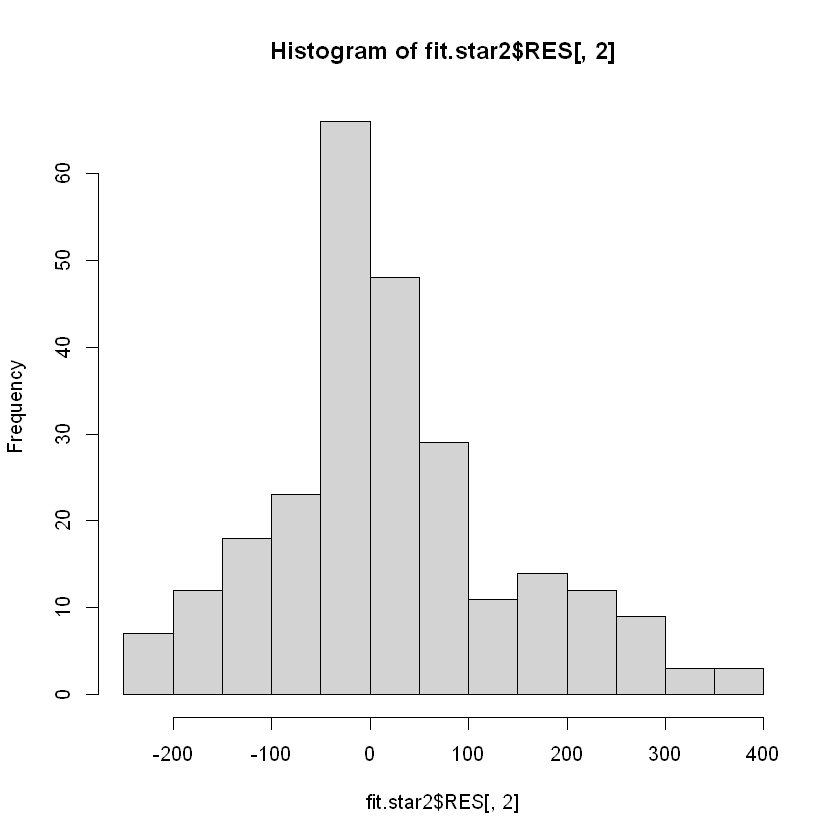

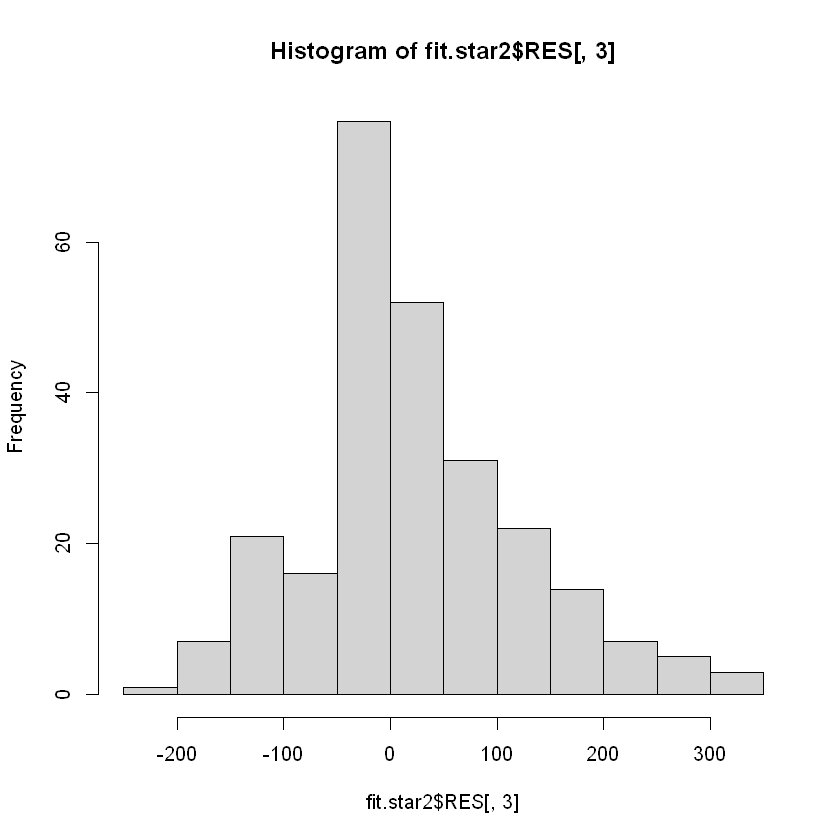

In [69]:
# Histogram of residual
hist(fit.star2$RES[,1])
hist(fit.star2$RES[,2])
hist(fit.star2$RES[,3])

In [70]:
# Perform the Ljung-Box test on the residuals of the STARIMA model
#JATIM_18 -> STARIMA(1,0,2) -> Best model
Box.test(fit.star2$RES[,1],lag=1, type="Ljung")
#JATIM_21 -> STARIMA(1,0,2) -> Best model
Box.test(fit.star2$RES[,2],lag=1, type="Ljung")
#JATIM_22 -> STARIMA(1,0,2) -> Best model
Box.test(fit.star2$RES[,3],lag=1, type="Ljung")


	Box-Ljung test

data:  fit.star2$RES[, 1]
X-squared = 3.1362, df = 1, p-value = 0.07657



	Box-Ljung test

data:  fit.star2$RES[, 2]
X-squared = 1.7988, df = 1, p-value = 0.1799



	Box-Ljung test

data:  fit.star2$RES[, 3]
X-squared = 0.70414, df = 1, p-value = 0.4014


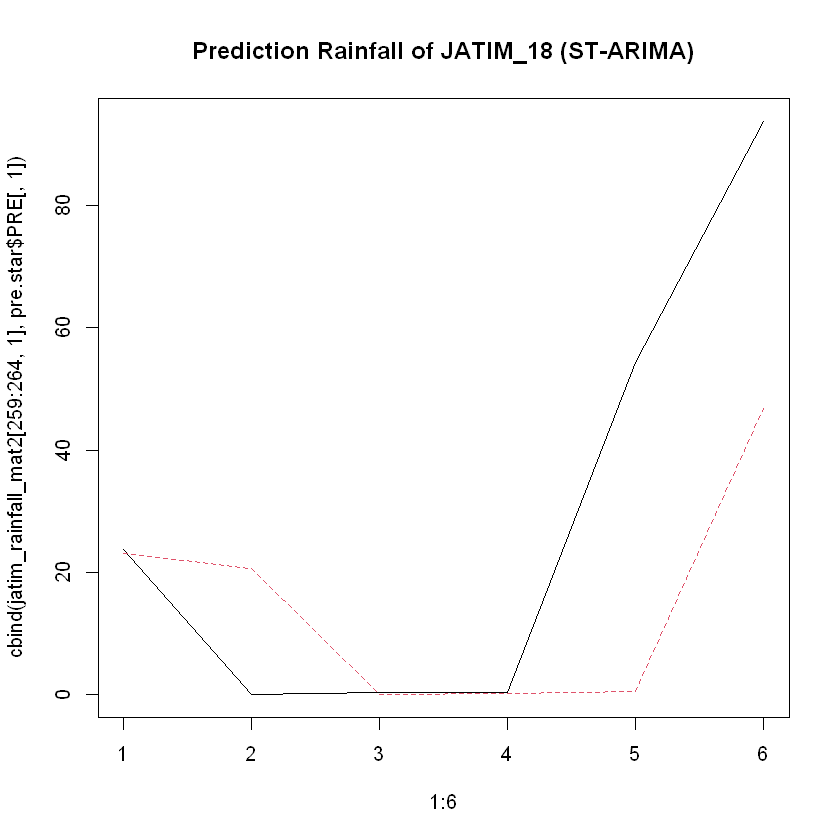

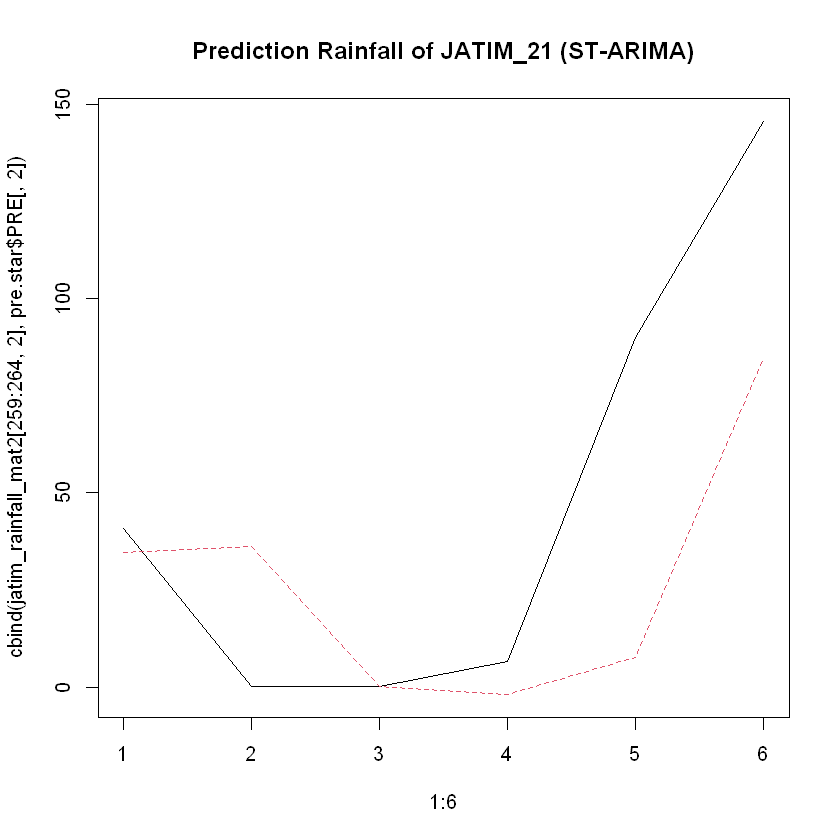

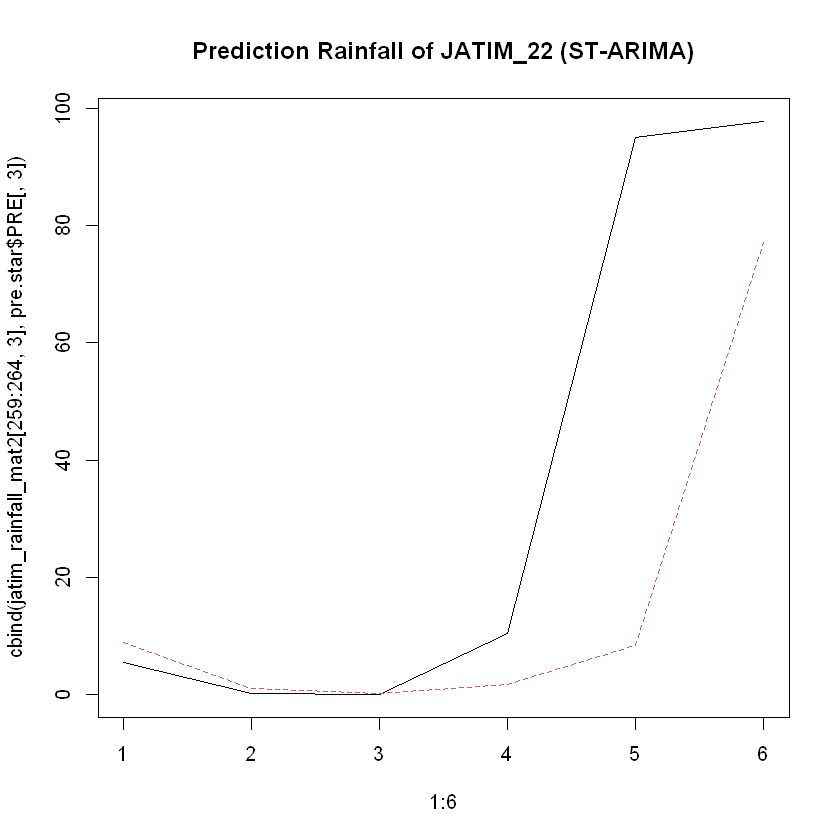

In [71]:
#PREDICTION
pre.star <- starima_pre(jatim_rainfall_mat2[(258-0-3+1):264,],
                        model=fit.star2)
matplot(1:6,cbind(jatim_rainfall_mat2[259:264,1],pre.star$PRE[,1]),type="l", main="Prediction Rainfall of JATIM_18 (ST-ARIMA)")
matplot(1:6,cbind(jatim_rainfall_mat2[259:264,2],pre.star$PRE[,2]),type="l", main="Prediction Rainfall of JATIM_21 (ST-ARIMA)")
matplot(1:6,cbind(jatim_rainfall_mat2[259:264,3],pre.star$PRE[,3]),type="l", main="Prediction Rainfall of JATIM_22 (ST-ARIMA)")

In [72]:
#Check the NRMSE of the ST-ARIMA Prediction
pre.star$NRMSE

[1] 0.7910795 0.7519799 0.7643199

## Discussion and Conclusion

**ST-ARIMA model outperforms the ARIMA model in all seasonal zones, displaying better prediction plots and lower NRMSE values.** The superior performance of the STARIMA model over the univariate ARIMA model may be attributed to the inclusion of spatial information, specifically the neighboring effect represented by the spatial weight matrix. In terms of interpretability and ease of implementation, ST-ARIMA is superior because model identification is performed only once and then applied to all areas. This results in faster computation times, especially when analyzing multiple areas simultaneously. The performance of the ARIMA and ST-ARIMA models varies across different areas due to the unique characteristics of rainfall in each region. However, both models effectively interpret the variations in the time series data and generate meaningful forecasts. It is important to note that these models have limitations; they are suitable only for short-term predictions in time series data, and the quality of the results is highly influenced by the training data. Furthermore, it is observed that the prediction plots and accuracy values of both models are moderately low. To enhance performance, longer historical data can be utilized to help the models better understand patterns and thereby produce more accurate predictions. **To conclude, the ST-ARIMA(1,0,2) outperforms ARIMA models in all seasonal zone and could be used to forecast short-time future rainfall in Jawa Timur.**

Check out my full publication on [GitHub](https://github.com/adefebrisp/RainfallForecast-ARIMA-STARIMA).